# {PAPER NAME HERE!} - Result analysis

This notebook demonstrates the workflow for processing the results for the paper {PAPER NAME HERE!}. 

### Prerequisites
In order to run this notebook it is recommended to install a conda distribution like [Anaconda or Miniconda (click for a link)](https://www.anaconda.com/download/success) and to create a new environment based on this repository's `environment.yml` file. The code in this notebook will not be guaranteed to work otherwise.


**Conda configuration guide:**

After installing a conda distribution, open a terminal (On windows it might be required to open the "Anaconda Terminal" instead).

Then navigate to the root folder of this repository inside of the terminal in order to have access to the `environment.yml` file.

Then run the following command to create/import the enviroment from the file: `conda env create -f environment.yml -n ml-results-analysis`

And the second command to activate the environment: `conda activate ml-results-analysis`.

Then using Jupyter Notebook or VS Code switch the kernel to the name of the newly created environment (which by default is "ml-results-analysis")

### Imports

Please make sure to run the following code block in order to import the packages required for analysis

In [53]:
import pandas as pd
import numpy as np

import os
from pathlib import Path

from scipy.stats import entropy

### Defining maps

Since some of the variables mapped can be unclear without using the user guide codebook, the relevant ones for this paper have been defined in these dictionaries.

In [ ]:
var_to_label_map = {
    "V200001": "ID",
    "V201549x": "Race/Ethnicity",
    "V202022": "Do you ever discuss politics with your family or friends?",
    "V201200": "Ideology (Self-reported liberal–conservative scale)",
    "V201231x": "Party Identification (7-point scale)",
    "V201452": "Church Attendance",
    "V201507x": "Age",
    "V201600": "Gender",
    "V202406": "Interest in Politics"
}

var_to_value_label_map = {
    "V201549x": { #"Race/Ethnicity"
        -9: "Refused",
        -8: "Don't know",
        1: "White, non-Hispanic",
        2: "Black, non-Hispanic",
        3: "Hispanic",
        4: "Asian or Native Hawaiian/Pacific Islander, non-Hispanic",
        5: "Native American/Alaska Native or other race, non-Hispanic",
        6: "Multiple races, non-Hispanic"
    },
    "V202022": { #"Do you ever discuss politics with your family or friends?"
        -9: "Refused",
        -7: "No post-election data, deleted due to incomplete interview",
        -6: "No post-election interview",
        1: "Yes",
        2: "No"
    },
    "V201200": { #"Ideology (Self-reported liberal–conservative scale)"
        -9: "Refused",
        -8: "Don't know",
        -7: "No post-election data, deleted due to incomplete interview",
        -6: "No post-election interview",
        1: "Extremely liberal",
        2: "Liberal",
        3: "Slightly liberal",
        4: "Moderate; middle of the road",
        5: "Slightly conservative",
        6: "Conservative",
        7: "Extremely conservative"
    },
    "V201231x": { #"Party Identification (7-point scale)"
        -9: "Refused",
        -8: "Don't know",
        1: "Strong Democrat",
        2: "Weak Democrat",
        3: "Independent–Democrat",
        4: "Independent–Independent",
        5: "Independent–Republican",
        6: "Weak Republican",
        7: "Strong Republican"
    },
    "V201452": { #"Church Attendance"
        -9: "Refused",
        -8: "Don't know",
        -1: "Inapplicable",
        1: "Every week",
        2: "Almost every week",
        3: "Once or twice a month",
        4: "A few times a year",
        5: "Seldom",
        6: "Never"
    },
    "V201507x": { #"Age"
        -9: "Refused",
        -8: "Don't know",
        -1: "Inapplicable",
        # Positive values are actual numeric ages (e.g., 18–90+)
    },
    "V201600": { #"Gender"
        -9: "Refused",
        -8: "Don't know",
        1: "Male",
        2: "Female"
    },
    "V202406": { #"Interest in Politics"
        -9: "Refused",
        -8: "Don't know",
        -7: "No post-election data, deleted due to incomplete interview",
        -6: "No post-election interview",
        1: "Very interested in politics",
        2: "Somewhat interested",
        3: "Not very interested",
        4: "Not at all interested"
    }
}

normal_question_map = {
    "V201324": "What do you think about the state of the economy these days in the United States?",
    "V201416": "Which comes closest to your view? You can just tell me the number of your choice.",
    "V202234": "Do you favor, oppose, or neither favor nor oppose allowing refugees who are fleeing war, persecution, or natural disasters in other countries to come to live in the U.S.?",
    "V202257": "Do you favor, oppose, or neither favor nor oppose the government trying to reduce the difference in incomes between the richest and poorest households?",
    "V202287": "Do you think it is better, worse, or makes no difference for the family as a whole if the man works outside the home and the woman takes care of the home and family?",
    "V202332": "How much, if at all, do you think climate change is currently affecting severe weather events or temperature patterns in the United States?",
    "V202337": "Do you think the federal government should make it more difficult for people to buy a gun than it is now, make it easier for people to buy a gun, or keep these rules about the same as they are now?",
    "V202348": "Do you think the federal government should be doing more about the opioid drug addiction issue, should be doing less, or is it currently doing the right amount?",
    "V202371": "Does the increasing number of people of many different races and ethnic groups in the United States make this country a better place to live, a worse place to live, or does it make no difference?",
    "V202378": "Do you favor an increase, decrease, or no change in government spending to help people pay for health insurance when people can’t pay for it all themselves?"
}

normal_answer_map = {
    "V201324": {1:"Very good", 2:"Good", 3:"Neither good nor bad", 4:"Bad", 5:"Very bad"},
    "V201416": {1:"Gay and lesbian couples should be allowed to legally marry", 2:"Gay and lesbian couples should be allowed to form civil unions but not legally marry", 3:"There should be no legal recognition of gay or lesbian couples’ relationship"},
    "V202234": {1:"Favor", 2:"Oppose", 3:"Neither favor nor oppose"},
    "V202257": {1:"Favor", 2:"Oppose", 3:"Neither favor nor oppose"},
    "V202287": {1:"Better", 2:"Worse", 3:"Makes no difference"},
    "V202332": {1:"Not at all", 2:"A little", 3:"A moderate amount", 4:"A lot", 5:"A great deal"},
    "V202337": {1:"More difficult", 2:"Easier", 3:"Keep these rules about the same"},
    "V202348": {1:"Should be doing more", 2:"Should be doing less", 3:"Is doing the right amount"},
    "V202371": {1:"Better", 2:"Worse", 3:"Makes no difference"},
    "V202378": {1:"Increase", 2:"Decrease", 3:"No change"}
}

reverse_question_map = {
    "V201416": "Which one disagrees the most with this respondent’s view?",
    "V202234": "What is this respondent’s position on whether refugees who are fleeing war, persecution, or natural disasters in other countries should be prohibited from coming to live in the U.S.?",
    "V202257": "How would this respondent assess whether the government should stop trying to reduce the difference in incomes between the richest and poorest households?",
    "V202287": "How would this respondent describe the impact on the family as a whole if both the man and the woman share work outside the home and take care of the home and family?",
    "V202332": "How much would this respondent agree with the statement that climate change is unrelated to severe weather events or temperature patterns in the United States?",
    "V202371": "How would this respondent describe the impact of limiting increases in the number of people of many different races and ethnic groups on the United States as a place to live?"
}

reverse_answer_map = {
    "V201416": {1:"Gay and lesbian couples should be allowed to legally marry", 2:"Gay and lesbian couples should be allowed to form civil unions but not legally marry", 3:"There should be no legal recognition of gay or lesbian couples’ relationship"},
    "V202234": {1:"Should be prohibited", 2:"Should not be prohibited", 3:"No clear position"},
    "V202257": {1:"Should stop trying", 2:"Should not stop trying", 3:"Neither of these"},
    "V202287": {1:"Improves the family as a whole", 2:"Worsens the family as a whole", 3:"Makes no difference"},
    "V202332": {1:"Not at all", 2:"A little", 3:"A moderate amount", 4:"A lot", 5:"A great deal"},
    "V202371": {1:"Improves it as a place", 2:"Worsens it as a place to live", 3:"Makes no difference"}
}

reform_question_map = {
    "V201324": "How would this respondent describe the state of the economy these days in the United States?",
    "V201416": "Which comes closest to this respondent’s view?",
    "V202234": "What is this respondent’s position on whether refugees who are fleeing war, persecution, or natural disasters in other countries should be allowed to come to live in the U.S.?",
    "V202257": "How would this respondent assess whether the government should be trying to reduce the difference in incomes between the richest and poorest households?",
    "V202287": "How would this respondent describe the impact on the family as a whole if the man works outside the home and the woman takes care of the home and family?",
    "V202332": "How would this respondent assess how much, if at all, climate change is currently affecting severe weather events or temperature patterns in the United States?",
    "V202337": "What is this respondent’s position on whether the federal government should make it more difficult for people to buy a gun than it is now, make it easier for people to buy a gun, or keep these rules about the same as they are now?",
    "V202348": "How would this respondent assess whether the federal government should be doing more about the opioid drug addiction issue, should be doing less, or is it currently doing the right amount?",
    "V202371": "How would this respondent describe the impact of the increasing number of people of many different races and ethnic groups on the United States as a place to live?",
    "V202378": "How would this respondent assess if there should be an increase, decrease, or no change in government spending to help people pay for health insurance when people cannot pay for it all themselves?"
}

reform_answer_map = {
    "V201324": {1:"Very strong", 2:"Strong", 3:"Neither strong nor weak", 4:"Weak", 5:"Very weak"},
    "V201416": {1:"Gay and lesbian couples should be allowed to legally marry", 2:"Gay and lesbian couples should be allowed to form civil unions but not legally marry", 3:"There should be no legal recognition of gay or lesbian couples’ relationship"},
    "V202234": {1:"Should be allowed", 2:"Should not be allowed", 3:"No clear position"},
    "V202257": {1:"Should be trying", 2:"Should not be trying", 3:"Neither of these"},
    "V202287": {1:"Improves the family as a whole", 2:"Worsens the family as a whole", 3:"Makes no difference"},
    "V202332": {1:"Not at all", 2:"A little", 3:"A moderate amount", 4:"A lot", 5:"A great deal"},
    "V202337": {1:"More difficult", 2:"Easier", 3:"Keep these rules about the same"},
    "V202348": {1:"Should be doing more", 2:"Should be doing less", 3:"Is doing the right amount"},
    "V202371": {1:"Improves it as a place", 2:"Worsens it as a place to live", 3:"Makes no difference"},
    "V202378": {1:"Increase", 2:"Decrease", 3:"No change"}
}

### Loading data

We first load the human responses.

In [35]:
df_anes_human_raw = pd.read_csv("data/2020 ANES_test.csv")

C:\Users\Saber\AppData\Local\Temp\ipykernel_26088\4170053218.py:1: DtypeWarning: Columns (19,21,22,23,25,26,27,29,30,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anes_human_raw = pd.read_csv("data/2020 ANES_test.csv")


We define the ID, features and question labels in lists.

In [36]:

questions = ["V201324",
    "V201416",
    "V202234",
    "V202257",
    "V202287",
    "V202332",
    "V202337",
    "V202348",
    "V202371",
    "V202378"]

relevant_columns = ["V200001", #id
    "V201549x",#vars
    "V202022",
    "V201200",
    "V201231x",
    "V201452",
    "V201507x",
    "V201600",
    "V202406"]


In [57]:
df_anes_human_data = df_anes_human_raw[relevant_columns + questions]

display(df_anes_human_data.head())
print(df_anes_human_data.info())


,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201324,V201416,V202234,V202257,V202287,V202332,V202337,V202348,V202371,V202378
0,300038,2,1,5,1,2,33,1,2,4,3,3,3,3,3,3,1,3,3
1,300076,2,-6,4,3,1,67,2,-6,3,2,-6,-6,-6,-6,-6,-6,-6,-6
2,300083,1,1,7,6,1,36,2,3,4,3,3,2,1,1,1,1,1,2
3,300106,1,1,5,7,1,80,2,2,3,1,3,2,1,4,1,-9,3,3
4,300113,1,1,1,3,2,21,2,2,4,1,1,1,3,5,1,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5441 entries, 0 to 5440
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   V200001   5441 non-null   int64
 1   V201549x  5441 non-null   int64
 2   V202022   5441 non-null   int64
 3   V201200   5441 non-null   int64
 4   V201231x  5441 non-null   int64
 5   V201452   5441 non-null   int64
 6   V201507x  5441 non-null   int64
 7   V201600   5441 non-null   int64
 8   V202406   5441 non-null   int64
 9   V201324   5441 non-null   int64
 10  V201416   5441 non-null   int64
 11  V202234   5441 non-null   int64
 12  V202257   5441 non-null   int64
 13  V202287   5441 non-null   int64
 14  V202332   5441 non-null   int64
 15  V202337   5441 non-null   int64
 16  V202348   5441 non-null   int64
 17  V202371   5441 non-null   int64
 18  V202378   5441 non-null   int64
dtypes: int64(19)
memory usage: 807.8 KB
None


We now load the LLM responses into a dictionary per condition.

In [ ]:
base_path = Path(r"MLMM Results")

condition_folders = [
    "main_mq_results",
    "main_mq_reform_results",
    "main_mq_reform_3rdP_Results",
    "main_mq_reverse_results",
    "main_mq_reverse_3rdP_results"
]

condition_dfs = {}

for folder in condition_folders:
    folder_path = base_path / folder
    csv_files = sorted(folder_path.glob("*.csv"))

    merged_df = None

    for csv_path in csv_files:
        var_code = csv_path.stem.split("_")[-1]

        df = pd.read_csv(csv_path)

        df = df.drop(columns=[c for c in df.columns if "prompt" in c.lower()], errors="ignore")

        if "Response" in df.columns:
            df = df.rename(columns={"Response": var_code})

        keep_cols = ["ID"] + [c for c in df.columns if c.startswith("V20") and c != var_code] + [var_code]
        df = df[keep_cols]

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df[["ID", var_code]], on="ID", how="outer")

    # Rename and save this folder's full merged dataframe
    merged_df = merged_df.rename(columns={"ID": "V200001"})
    condition_dfs[folder] = merged_df

for cond in condition_folders:
    display(condition_dfs[cond].head())



,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201324,V201416,V202234,V202257,V202287,V202332,V202337,V202348,V202371,V202378
0,fake_0,1,1,2,7,2,34,2,-6,4,1,1,1,3,3,1,1,1,1
1,fake_1,1,2,7,4,2,58,2,2,4,1,1,1,3,3,3,1,1,1
2,fake_10,1,1,2,1,2,38,1,2,4,1,1,1,3,3,3,1,1,1
3,fake_100,1,1,4,6,1,-9,1,-6,3,1,1,1,1,4,3,1,1,1
4,fake_1000,1,1,99,2,2,48,2,2,4,1,1,1,3,3,3,1,1,1


,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201324,V201416,V202234,V202257,V202287,V202332,V202337,V202348,V202371,V202378
0,fake_0,1,1,99,4,2,21,2,3,3,1,1,1,1,3,3,1,1,1
1,fake_1,1,-6,6,1,1,43,2,1,4,1,1,1,3,4,3,1,1,1
2,fake_10,1,1,2,2,1,68,1,1,4,1,1,1,1,3,3,1,1,1
3,fake_100,1,1,99,1,2,71,2,2,4,3,1,1,3,3,3,1,2,1
4,fake_1000,1,1,7,1,2,69,2,2,4,1,1,1,1,4,3,1,1,1


,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201324,V201416,V202234,V202257,V202287,V202332,V202337,V202348,V202371,V202378
0,fake_0,-9,-6,6,2,2,40,2,-6,4,1,1,1,1,4,1,1,1,2
1,fake_1,2,-6,4,4,2,53,2,2,4,1,1,2,1,3,2,1,1,1
2,fake_10,1,1,1,6,2,59,1,2,4,1,1,2,1,3,3,1,1,1
3,fake_100,1,1,1,5,2,58,2,1,4,1,1,1,3,3,3,1,1,1
4,fake_1000,1,1,5,4,1,-9,2,3,3,1,2,1,1,2,1,1,1,1


,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201416,V202234,V202257,V202287,V202332,V202371
0,fake_0,1,-6,99,1,1,75,2,-6,3,2,2,1,2,2
1,fake_1,1,1,99,5,1,47,2,4,3,2,2,1,4,2
2,fake_10,3,1,2,7,2,77,2,-6,3,2,2,1,1,2
3,fake_100,1,-6,5,3,2,32,2,2,3,2,2,1,1,2
4,fake_1000,1,2,6,2,2,60,2,4,3,2,2,1,1,2


,V200001,V201549x,V202022,V201200,V201231x,V201452,V201507x,V201600,V202406,V201416,V202234,V202257,V202287,V202332,V202371
0,fake_0,1,1,4,6,1,45,2,-6,3,2,2,1,4,2
1,fake_1,1,1,4,5,2,68,1,3,3,2,2,1,2,2
2,fake_10,1,-6,2,4,1,41,2,2,3,1,2,1,2,2
3,fake_100,1,1,5,1,2,32,2,2,3,2,2,1,2,3
4,fake_1000,1,-6,99,7,1,70,1,4,3,2,2,1,4,2


### Evaluation

In this section we calculate the KL-divergence for each condition question combination

In [69]:
EPS = 1e-9

human_df = df_anes_human_data

question_cols = [c for c in questions]

results = []

for cond_name, ai_df in condition_dfs.items():
    for q in question_cols:
        if q not in ai_df.columns:
            continue  # skip questions not asked in this condition

        # convert to numeric (errors='coerce' turns strings to NaN)
        human = pd.to_numeric(human_df[q], errors="coerce")
        ai = pd.to_numeric(ai_df[q], errors="coerce")

        # drop negative / missing codes (ANES uses -9, -8, etc.)
        human = human[human > 0]
        ai = ai[ai > 0]

        # compute normalized distributions
        human_dist = human.value_counts(normalize=True).sort_index()
        ai_dist = ai.value_counts(normalize=True).sort_index()

        # align categories
        all_cats = sorted(set(human_dist.index) | set(ai_dist.index))
        human_probs = np.array([human_dist.get(c, 0) for c in all_cats]) + EPS
        ai_probs = np.array([ai_dist.get(c, 0) for c in all_cats]) + EPS

        # normalize
        human_probs /= human_probs.sum()
        ai_probs /= ai_probs.sum()

        kl_value = entropy(human_probs, ai_probs)  # D_KL(P||Q)

        results.append({
            "condition": cond_name,
            "question": q,
            "KL_divergence": kl_value
        })

results_df = pd.DataFrame(results)
pivot_df = results_df.pivot(index="question", columns="condition", values="KL_divergence")

display(results_df)
display(pivot_df)


,condition,question,KL_divergence
0,main_mq_results,V201324,7.646686
1,main_mq_results,V201416,1.250258
2,main_mq_results,V202234,6.707968
3,main_mq_results,V202257,0.746206
4,main_mq_results,V202287,0.046983
5,main_mq_results,V202332,9.193323
6,main_mq_results,V202337,0.393102
7,main_mq_results,V202348,5.586736
8,main_mq_results,V202371,1.761093
9,main_mq_results,V202378,2.711669


condition,main_mq_reform_3rdP_Results,main_mq_reform_results,main_mq_results,main_mq_reverse_3rdP_results,main_mq_reverse_results
question,,,,,
V201324,3.242370,3.350287,7.646686,NaN,NaN
V201416,0.214560,0.122211,1.250258,17.249748,17.249748
V202234,6.042526,6.189727,6.707968,7.205800,2.884465
V202257,1.115637,1.455088,0.746206,2.741388,6.516017
V202287,1.637837,1.974599,0.046983,5.448786,13.768992
V202332,8.917085,9.285117,9.193323,2.051191,2.640106
V202337,0.191042,0.169523,0.393102,NaN,NaN
V202348,1.662727,5.586736,5.586736,NaN,NaN
V202371,0.556788,1.016952,1.761093,11.512975,12.163273


We now apply bootstrapping

In [71]:
def bootstrap_kl_ci(human_series, ai_series, n_boot=500, alpha=0.05):
    # convert to numeric, drop invalid codes
    human = pd.to_numeric(human_series, errors="coerce")
    ai = pd.to_numeric(ai_series, errors="coerce")
    human = human[human > 0]
    ai = ai[ai > 0]
    
    if len(human) == 0 or len(ai) == 0:
        return np.nan, (np.nan, np.nan)

    # base distribution (human)
    human_dist = human.value_counts(normalize=True).sort_index()
    all_cats = sorted(human_dist.index.union(ai.value_counts().index))

    # compute baseline KL
    def compute_kl(a):
        a_dist = pd.Series(a).value_counts(normalize=True).sort_index()
        ai_probs = np.array([a_dist.get(c, 0) for c in all_cats]) + 1e-9
        ai_probs /= ai_probs.sum()
        human_probs = np.array([human_dist.get(c, 0) for c in all_cats]) + 1e-9
        human_probs /= human_probs.sum()
        return entropy(human_probs, ai_probs)

    base_kl = compute_kl(ai)

    # bootstrap resampling
    kl_samples = []
    for _ in range(n_boot):
        resampled_ai = np.random.choice(ai, size=len(ai), replace=True)
        kl_samples.append(compute_kl(resampled_ai))

    lower = np.percentile(kl_samples, 100 * (alpha / 2))
    upper = np.percentile(kl_samples, 100 * (1 - alpha / 2))

    return base_kl, (lower, upper)


In [72]:
results = []

for cond_name, ai_df in condition_dfs.items():
    for q in question_cols:
        if q not in ai_df.columns:
            continue
        
        kl, (lower, upper) = bootstrap_kl_ci(
            human_series=human_df[q],
            ai_series=ai_df[q],
            n_boot=500  # maybe 1000 for stability
        )

        results.append({
            "condition": cond_name,
            "question": q,
            "KL_divergence": kl,
            "KL_CI_lower": lower,
            "KL_CI_upper": upper
        })

results_df = pd.DataFrame(results)


In [73]:
display(results_df)

,condition,question,KL_divergence,KL_CI_lower,KL_CI_upper
0,main_mq_results,V201324,7.646686,7.634079,7.659146
1,main_mq_results,V201416,1.250258,1.039063,3.410274
2,main_mq_results,V202234,6.707968,6.581730,8.477455
3,main_mq_results,V202257,0.746206,0.697274,0.796467
4,main_mq_results,V202287,0.046983,0.039208,0.056083
5,main_mq_results,V202332,9.193323,9.157944,9.247106
6,main_mq_results,V202337,0.393102,0.364982,0.429432
7,main_mq_results,V202348,5.586736,5.586736,5.586736
8,main_mq_results,V202371,1.761093,1.716299,1.810087
9,main_mq_results,V202378,2.711669,2.309390,6.705700


### Visualization

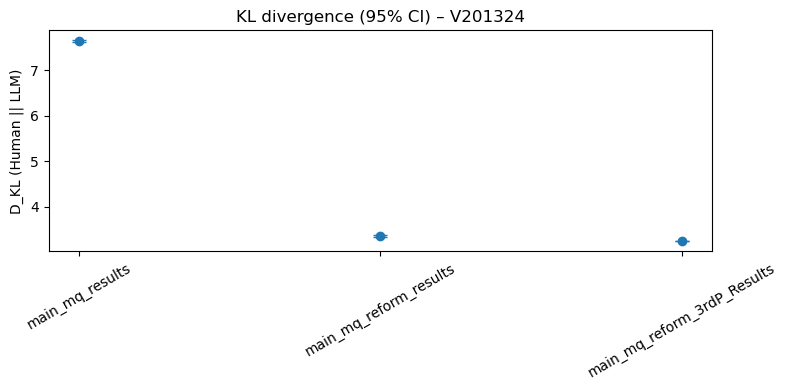

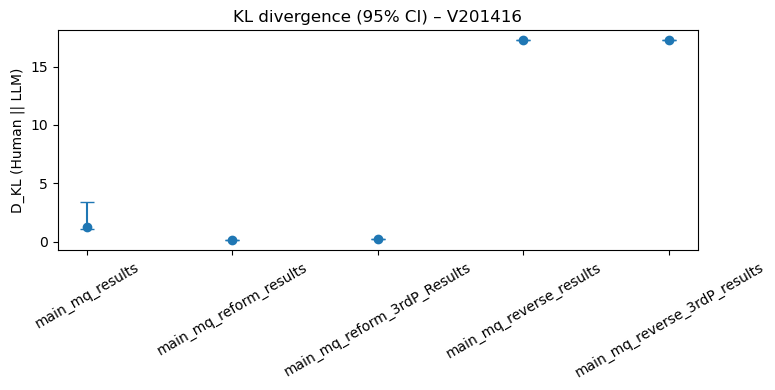

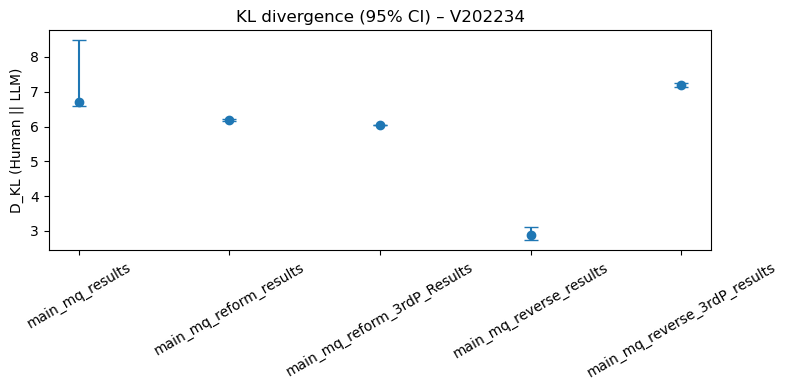

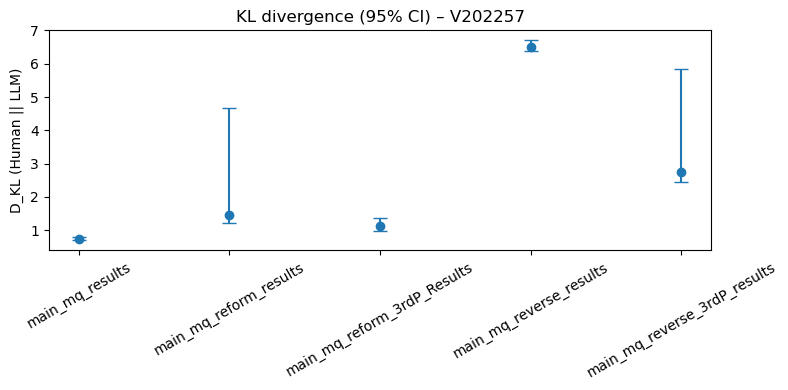

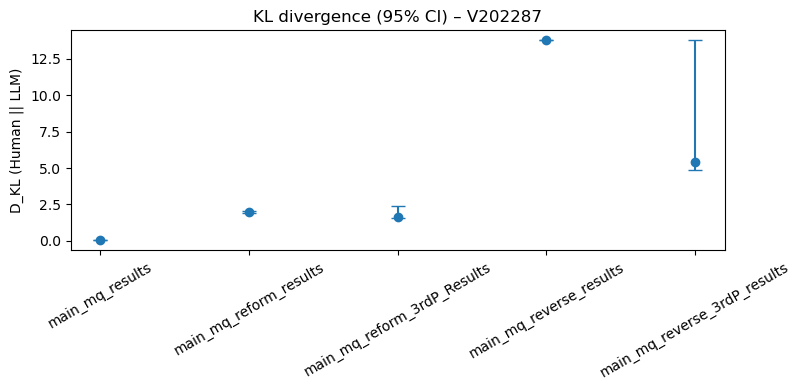

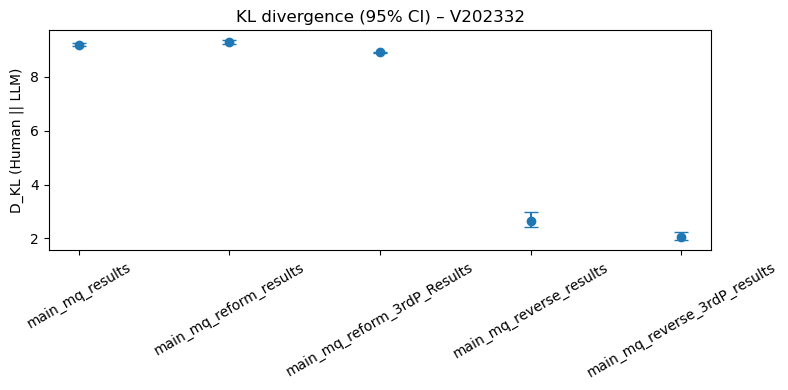

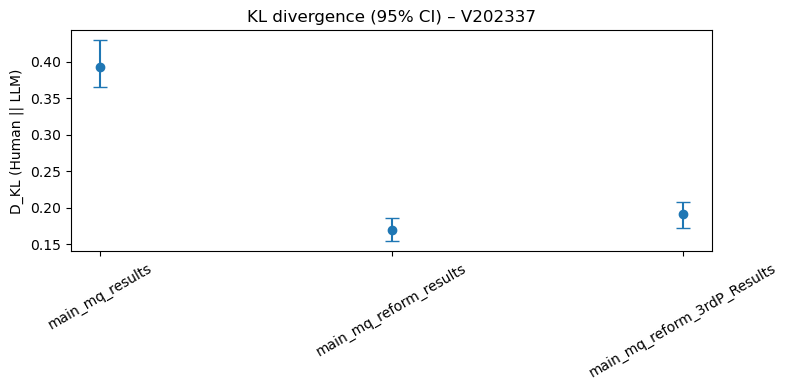

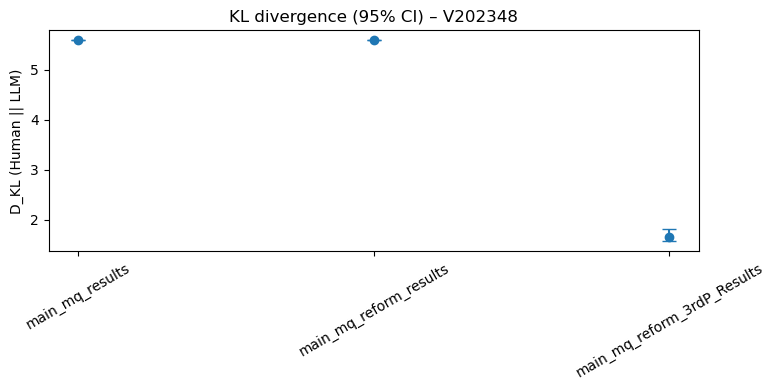

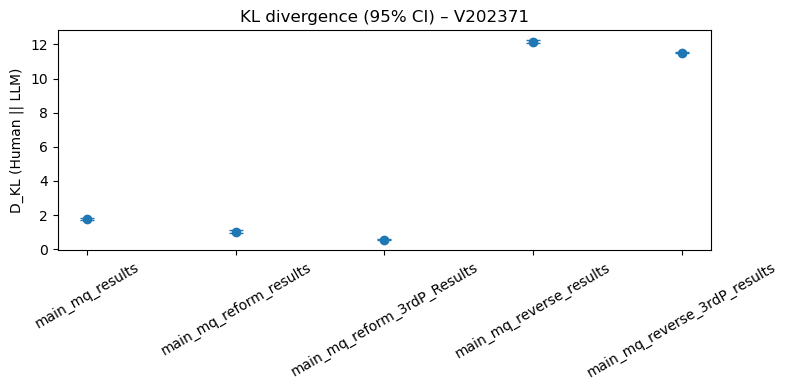

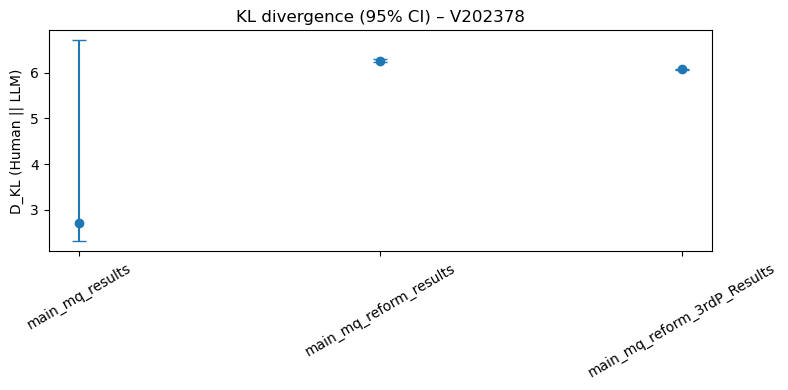

In [74]:
import matplotlib.pyplot as plt

for q in results_df["question"].unique():
    subset = results_df[results_df["question"] == q]
    plt.figure(figsize=(8,4))
    plt.errorbar(subset["condition"], subset["KL_divergence"],
                 yerr=[subset["KL_divergence"] - subset["KL_CI_lower"],
                       subset["KL_CI_upper"] - subset["KL_divergence"]],
                 fmt='o', capsize=5)
    plt.title(f"KL divergence (95% CI) – {q}")
    plt.ylabel("D_KL (Human || LLM)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()